# Directory

In [5]:
import numpy as np
import pandas as pd

import os
for dirpath, dirnames, filenames in os.walk('./datasets'):
    for filename in [f for f in filenames if f.endswith(".csv")]:
        print(os.path.join(dirpath, filename))

./datasets\clean_dataset\df_tourism.csv
./datasets\indonesia-tourism\package_tourism.csv
./datasets\indonesia-tourism\tourism_rating.csv
./datasets\indonesia-tourism\tourism_with_id.csv
./datasets\indonesia-tourism\user.csv


# Import Libraries

In [6]:
!pip install wordcloud==1.9.3

In [8]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
from wordcloud import WordCloud, STOPWORDS


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

# Read datasets

In [9]:
data_tourism_with_id = pd.read_csv('./datasets/indonesia-tourism/tourism_with_id.csv')
df_tourism = pd.read_csv('./datasets/clean_dataset/df_tourism.csv')

In [10]:
df_tourism.head()

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Location,Category_encoded,City_encoded
0,1.0,3.7222222222222223,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,"(-6.1753924, 106.8271528)",1.0,1.0
1,2.0,2.84,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,"(-6.1376448, 106.8171245)",1.0,1.0
2,3.0,2.526315789473684,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,"(-6.1253124, 106.8335377)",4.0,1.0
3,4.0,2.857142857142857,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,"(-6.3024459, 106.8951559)",4.0,1.0
4,5.0,3.52,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,"(-6.12419, 106.839134)",4.0,1.0


In [11]:
df_tourism.isna().sum()

Place_Id             5
Place_Ratings        0
Place_Name           0
Description          0
Category             5
City                 5
Location            10
Category_encoded    10
City_encoded        10
dtype: int64

# Modelling

## Content-Based Filtering

similarity

place_id, category, city

In [23]:
from functools import reduce
tourism_df = df_tourism

def parse_input(input_str):
    split_input = input_str.split(',')
    print(split_input)
    place_id_str = split_input[0] if len(split_input) > 0 else None
    city = split_input[1].strip() if len(split_input) > 1 else None
    category = split_input[2].strip() if len(split_input) > 2 else None

    place_id = int(place_id_str) if place_id_str else None
    print(place_id)

    return place_id, city, category

def apply_filters(df, city=None, category=None, place_id=None):
    filters = []
    if city:
        filters.append(df['City'] == city)
    if category:
        filters.append(df['Category'] == category)
    # if place_id:
    #     filters.append(df['Place_Id'] == place_id)
    # print(filters)
    if filters:
        filtered_df = df[reduce(lambda x, y: x & y, filters)]
        return filtered_df
    else:
        return df

def get_category_city_recommendations(input_user):
    place_id, city, category = parse_input(input_user)
    filtered_df= apply_filters(tourism_df, city=city, category=category, place_id=place_id)

    # print(filtered_df.head()) 

    # Compute the cosine similarity matrix for the filtered dataframe
    # text_features = recommendation_data['Description'] + ' ' + recommendation_data['Category'] + ' ' + recommendation_data['City']
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    # tfidf_matrix_recomendation = tfidf_vectorizer.fit_transform(text_features)
    tfidf_matrix_preference = tfidf_vectorizer.fit_transform(filtered_df['Description'] + ' ' + filtered_df['Category'] + ' ' + filtered_df['City'])
    # print(tfidf_matrix_preference)
    # print(tfidf_matrix_preference.shape)
    cosine_sim = cosine_similarity(linear_kernel(tfidf_matrix_preference, tfidf_matrix_preference))
    # print(cosine_sim)
    # Get the indices of the places
    if place_id:
        idx = tourism_df.index[tourism_df['Place_Id'] == place_id].tolist()[0]
    else:
        idx = 0

    # Get the cosine similarity scores for the target place
    cosine_scores = cosine_sim[idx]

    # Pair each cosine similarity score with its corresponding index
    similarity_with_indices = list(enumerate(cosine_scores))

    # Sort the similarity scores in descending order
    sorted_similarity = sorted(similarity_with_indices, key=lambda x: x[1], reverse=True)

    # Get the place indices
    place_indices = [i[0] for i in sorted_similarity]
    place_similarity = [i[1] for i in sorted_similarity]

    result_df = filtered_df.iloc[place_indices[:min(10, len(place_indices))]]
    result_df['Similarity_Score'] = place_similarity[:min(10, len(place_similarity))]
    return result_df

input_str = '1,Surabaya,Cagar Alam'

recommendations_all = get_category_city_recommendations(input_str)
print(recommendations_all)



['1', 'Surabaya', 'Cagar Alam']
1
     Place_Id       Place_Ratings               Place_Name  \
396     393.0  3.0476190476190474    Taman Harmoni Keputih   
409     406.0  2.8620689655172415     Kebun Bibit Wonorejo   
403     400.0  2.5217391304347827      Hutan Bambu Keputih   
411     408.0  2.8181818181818183  Kebun Binatang Surabaya   

                                           Description    Category      City  \
396  Tempat tersebut ialah Taman Hatmoni Keputih Su...  Cagar Alam  Surabaya   
409  Meskipun namanya kebun bibit, namun kawasan in...  Cagar Alam  Surabaya   
403  Surabaya menjadi kota metropolitan kedua setel...  Cagar Alam  Surabaya   
411  Kebun Binatang Surabaya (KBS) (Dialek Arekan: ...  Cagar Alam  Surabaya   

                      Location  Category_encoded  City_encoded  \
396  (-7.2952211, 112.8035603)               2.0           3.0   
409  (-7.3123655, 112.7889021)               2.0           3.0   
403  (-7.2941909, 112.8017238)               2.0        

C:\Users\Lim_LTP\AppData\Local\Temp\ipykernel_60848\3152463686.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Similarity_Score'] = place_similarity[:min(10, len(place_similarity))]


In [24]:
tourism_df

,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Location,Category_encoded,City_encoded
0,1.0,3.7222222222222223,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,"(-6.1753924, 106.8271528)",1.0,1.0
1,2.0,2.84,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,"(-6.1376448, 106.8171245)",1.0,1.0
2,3.0,2.526315789473684,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,"(-6.1253124, 106.8335377)",4.0,1.0
3,4.0,2.857142857142857,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,"(-6.3024459, 106.8951559)",4.0,1.0
4,5.0,3.52,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,"(-6.12419, 106.839134)",4.0,1.0
...,...,...,...,...,...,...,...,...,...
437,433.0,3.3043478260869565,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,"(-7.4338593, 112.7199058)",1.0,3.0
438,434.0,2.4,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,"(-7.2913468, 112.7398218)",4.0,3.0
439,435.0,3.0,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,"(-7.2752955, 112.7549381)",4.0,3.0
440,436.0,3.090909090909091,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,"(-7.2943303, 112.7617534)",4.0,3.0


# Word Cloud Generate

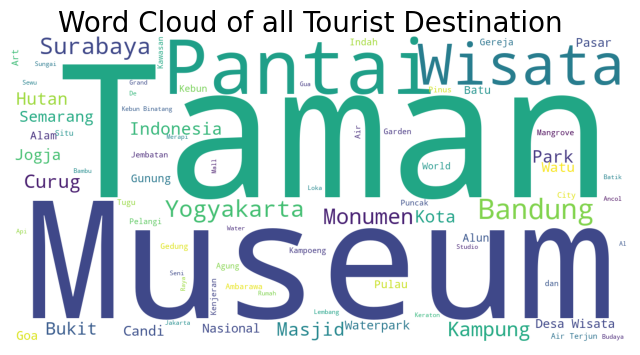

In [27]:
def wordcloud_generator(data, title = None):
    name_corpus = ' '.join(data['Place_Name'])
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = STOPWORDS,
        max_words = 550,
        scale = 3,
        random_state = 42
    ).generate(str(name_corpus))

    fig = plt.figure(1, figsize = (8, 4))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 0.95)

    plt.imshow(wordcloud)
    plt.show()

wordcloud_generator(tourism_df, title = 'Word Cloud of all Tourist Destination')

## Testing var atau function

In [28]:
np.random.seed(0)  # For reproducibility
user_ids = np.random.randint(1, 100, 1500)
place_ids = np.random.randint(1, 437, 1500)
ratings = np.random.randint(1, 6, 1500)
user_rating_dummy = pd.DataFrame({'User_Id': user_ids, 'Place_Id': place_ids, 'Rating': ratings})


user_rating_dummy.head()

,User_Id,Place_Id,Rating
0,45,28,3
1,48,233,4
2,65,376,4
3,68,148,5
4,68,400,3


# Model Collaborative Filtering

### Preprocessing

In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Simulate user_rating.csv with dummy data
np.random.seed(0)  # For reproducibility
user_ids = np.random.randint(1, 26, 1500)
place_ids = np.random.randint(1, 430, 1500)
ratings = np.random.randint(1, 6, 1500)

user_rating_dummy = pd.DataFrame({'User_Id': user_ids, 'Place_Id': place_ids, 'Rating': ratings})

# Load tourism_with_id.csv and drop unnecessary columns
tourism_df = data_tourism_with_id

coordinate_data = tourism_df[['Place_Id', 'Lat', 'Long']]
print(coordinate_data.head())

# Preprocessing
# Encode the user and place ids
encoder = LabelEncoder()
merged_data = pd.merge(user_rating_dummy, coordinate_data, on='Place_Id', how='left')

merged_data['User_Id'] = encoder.fit_transform(merged_data['User_Id'])
merged_data['Place_Id'] = encoder.fit_transform(merged_data['Place_Id'])
merged_data['Lat'] = encoder.fit_transform(merged_data['Lat'])
merged_data['Long'] = encoder.fit_transform(merged_data['Long'])

# Print the merged data
print(merged_data.head())

# Print unique counts
print("Number of unique Place Ids:", merged_data['Place_Id'].nunique())
print("Number of unique User Ids:", merged_data['User_Id'].nunique())
print("Number of unique Lat values:", merged_data['Lat'].nunique())
print("Number of unique Long values:", merged_data['Long'].nunique())

# Optionally, fill NaN values with a default value (e.g., 0)
# merged_data['Rating'].fillna(0, inplace=True)

# Optionally, save the processed data to a new CSV file
merged_data.to_csv('rating_coordinate.csv', index=False)
# user_rating_dummy.to_csv('user_rating_dummy.csv', index=False)

   Place_Id       Lat        Long
0         1 -6.175392  106.827153
1         2 -6.137645  106.817125
2         3 -6.125312  106.833538
3         4 -6.302446  106.895156
4         5 -6.124190  106.839134
   User_Id  Place_Id  Rating  Lat  Long
0       12       241       1  291   178
1       15       355       5  154   305
2       21       401       1  163   388
3        0       359       4  223   308
4        3        46       2  360    36
Number of unique Place Ids: 412
Number of unique User Ids: 25
Number of unique Lat values: 412
Number of unique Long values: 412


C:\Users\Lim_LTP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Split the data into train and test

In [30]:
# Split the data
X = merged_data[['User_Id', 'Place_Id']].values
y = merged_data[['Rating', 'Lat', 'Long']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_arr = [X_train[:, 0], X_train[:, 1]]
X_test_arr = [X_test[:, 0], X_test[:, 1]]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1200, 2) (300, 2) (1200, 3) (300, 3)


### Build and train the model (belum FIX)

25 412

(None, 1, 50)
(None, 50)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 place_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                1250      ['user_input[0][0]']          
                                                                                                  
 place_embedding (Embedding  (None, 1, 50)                20600     ['place_input[0][0]']         
 )                                                          

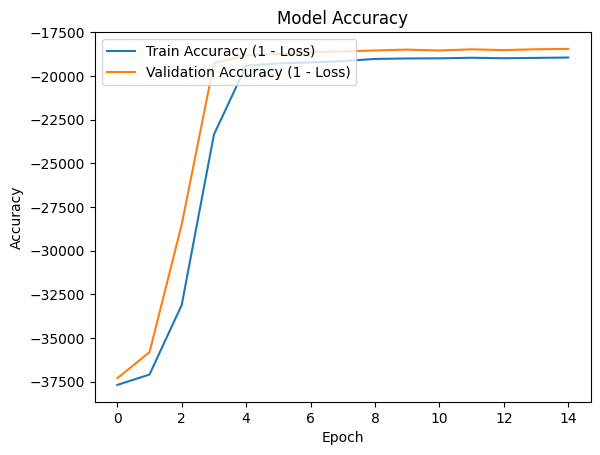

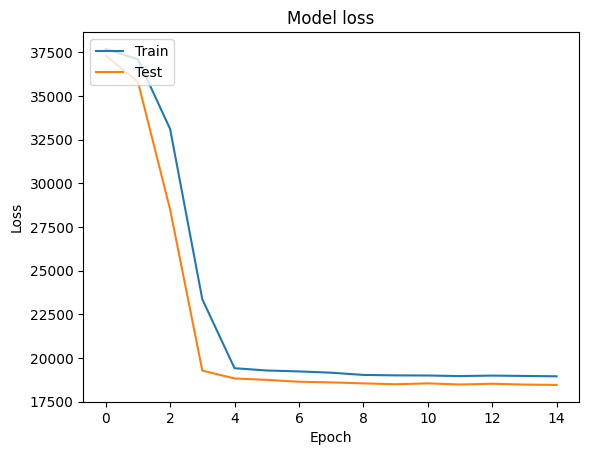

10/10 [==============================] - 0s 1ms/step - loss: 18454.9570 - accuracy: 0.0833
Test Loss: 18454.9570
Test MAE: 0.0833
Model training complete and saved as collaborative_filtering_model.h5


C:\Users\Lim_LTP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 140ms/step
Predicted Rating: 137.1680


In [31]:
from tensorflow.keras.layers import Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Reshape, Dot

# Model
# Set the variables for the number of factors, users, and items
n_factors = 50
n_users = user_rating_dummy['User_Id'].nunique()
n_places = user_rating_dummy['Place_Id'].nunique() 
print(n_users, n_places)

# Create the model
user_input = Input(shape=(1,), name='user_input')
place_input = Input(shape=(1,), name='place_input')

user_embedding = Embedding(n_users, n_factors, name='user_embedding', )(user_input)
place_embedding = Embedding(n_places, n_factors, name='place_embedding')(place_input)
print(place_embedding.shape)
user_vector = Reshape((n_factors,))(user_embedding)
place_vector = Reshape((n_factors,))(place_embedding)
print(place_vector.shape)
x = Concatenate()([user_vector, place_vector])
fc1 = Dense(64, activation='relu')(x)
fc2 = Dense(16, activation='relu')(fc1)
# fc3 = tf.keras.layers.Dropout(0.5)(fc2)
fc4 = tf.keras.layers.Dropout(0.3)(fc2)
# fc5 = tf.keras.layers.Dropout(0.1)(fc4)
out = Dense(1)(fc4)

# y = Dot(axes=1)([user_vector, place_vector])
# print (y)

model = Model(inputs=[user_input, place_input], outputs=out)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(x=X_train_arr,
             y=y_train, 
             batch_size=32,
             epochs=15,
             verbose=1, 
             validation_data=(X_test_arr, y_test)
             )

# plt.figure(figsize=(10, 5))
plt.plot([1 - x for x in history.history['loss']], label='Train Accuracy (1 - Loss)')
plt.plot([1 - x for x in history.history['val_loss']], label='Validation Accuracy (1 - Loss)')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the model
test_loss, test_mae = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Save the model
model.save('collaborative_filtering_model.h5')

print('Model training complete and saved as collaborative_filtering_model.h5')

# Make predictions
user_id_to_predict = 1
place_id_to_predict = 1

# Make a prediction
prediction = model.predict([np.array([user_id_to_predict]), np.array([place_id_to_predict])])
print(f'Predicted Rating: {prediction[0, 0]:.4f}')

In [32]:
# Prepare the LabelEncoder
user_encoder = LabelEncoder().fit(user_rating_dummy['User_Id'])
place_encoder = LabelEncoder().fit(user_rating_dummy['Place_Id'])
# print(user_encoder, place_encoder)
# Load the trained model
loaded_model = tf.keras.models.load_model('collaborative_filtering_model.h5')

# Simulate new user-item pairs for which you want to make predictions
new_user_ids = [22, 25, 21]
new_place_ids = [20, 20, 35]

# Encode the new user and place ids using the label encoders from training
new_user_ids_encoded = user_encoder.transform(new_user_ids)
new_place_ids_encoded = place_encoder.transform(new_place_ids)

print(new_user_ids_encoded, new_place_ids_encoded)

# Make predictions
predictions = loaded_model.predict([new_user_ids_encoded, new_place_ids_encoded])
print(predictions)
# Print the predictions
for i in range(len(new_user_ids)):
    print(f"Prediction for User {new_user_ids[i]} and Place {new_place_ids[i]}: {predictions[i][0]}")

[21 24 20] [19 19 33]
1/1 [==============================] - 0s 126ms/step
[[ 97.54816]
 [ 96.93734]
 [131.49956]]
Prediction for User 22 and Place 20: 97.54815673828125
Prediction for User 25 and Place 20: 96.93733978271484
Prediction for User 21 and Place 35: 131.4995574951172


### Test prediction

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

# Assuming recommendation_data is already defined
tourism_df = merged_data

# Encode categorical features using LabelEncoder
user_encoder = LabelEncoder()
place_encoder = LabelEncoder()
print(tourism_df.head())
tourism_df['User_Id'] = user_encoder.fit_transform(tourism_df['User_Id'])
tourism_df['Place_Id'] = place_encoder.fit_transform(tourism_df['Place_Id'])

# Load the trained model
model = load_model('collaborative_filtering_model.h5')

# Example input for prediction
example_user_id = user_encoder.transform([3])[0]
example_place_id = place_encoder.transform([46])[0]

# Make a prediction
predicted_rating = model.predict([np.array([example_user_id]), np.array([example_place_id])])

print(f'Predicted Rating: {predicted_rating[0][0]}')


   User_Id  Place_Id  Rating  Lat  Long
0       12       241       1  291   178
1       15       355       5  154   305
2       21       401       1  163   388
3        0       359       4  223   308
4        3        46       2  360    36
1/1 [==============================] - 0s 103ms/step
Predicted Rating: 124.0598373413086


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=738037d9-6841-4167-9a3b-dc0ac9a5875c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>